# Validation of the different aspects of the model

Four aspects of the model are compared to the observational data: events detection, density of the layers (through the SWE values), height of the layers and temperature profile.

## 0. Simulated snowpack creation

In [1]:
# Imports

%run little_awk_functions.py
%run parameters.py

In [2]:
# Clean dataset

data_set_used = xr.open_dataset('snow_pit_1_filled.nc')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].isel(x=x_sel, y=y_sel).dropna('time').min()

---> Median filtering in space with a window [7, 11]
---> Median filtering in time with a window of 11


In [3]:
# TODO refaire les cells suivantes for each point and store end data for stats?

In [4]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [5]:
# Get timing of events

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude (seconds)

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


In [6]:
# Simulate the snowpack

snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


## Useful functions for what follows

In [7]:
def get_data_from_marker(index_of_marker_layer, ro_layer_array, depth_array):
    '''
    Function that computes some characteristic values (SWE, height, average density) above a "marker" interface
    Args:
        index_of_marker_layer: index of the layer that is directly underneath the marker interface
        ro_layer_array: array of the densities of each layers at the end of the simulation
        depth_array: array of the heights of each layers at the end of the simulation
    Returns:
        swe_from_marker: value of the SWE above the given interface
        height_from_marker: height of the snowpack above the given interface
        ave_density_from_marker: averaged density of the snow above the given interface
    '''
    swe_from_marker = np.dot(np.array(ro_layer_array[index_of_marker_layer+1:]), np.array(depth_array[index_of_marker_layer+1:])) / 1000
    height_from_marker = sum(depth_array[i] for i in range(index_of_marker_layer+1, len(depth_array)))
    ave_density_from_marker = np.dot(np.array(ro_layer_array[index_of_marker_layer+1:]), np.array(depth_array[index_of_marker_layer+1:])) / height_from_marker
    
    return(swe_from_marker, height_from_marker, ave_density_from_marker)

In [56]:
def get_depth_layers_indices(bottom_depth, sampling_length, depth_array):
    '''
    Function that creates an array of the layer index at each (regularly) sampled depth (useful for computing profiles)
    Args:
        bottom_depth: depth of the lowest sample, in meters, counted positively from the surface of the snowpack downwards (included)
        sampling_length: height between two consecutive sampled depths
        depth_array: array of the heights of each layers, in meters, at the end of the simulation
    Returns:
        layers_array: array containing the indices of the layers corresponding to each sampled depth (which layer was sampled)
    '''
    current_layer_index = next(len(depth_array) - i for i, j in enumerate(reversed(depth_array), 1) if j != 0)
    remaining_depth_in_current_layer = depth_array[current_layer_index]
    current_depth = 0
    layers_array = [current_layer_index]    # top of the snowpack
    leftover_depth = sampling_length
    
    while current_depth < bottom_depth and current_layer_index > -1:
        while remaining_depth_in_current_layer >= sampling_length and current_depth < bottom_depth:
            layers_array.append(current_layer_index)
            remaining_depth_in_current_layer -= sampling_length
            current_depth += sampling_length
        while remaining_depth_in_current_layer < leftover_depth and current_depth < bottom_depth and current_layer_index > -1:
            leftover_depth -= remaining_depth_in_current_layer
            current_layer_index -= 1
            remaining_depth_in_current_layer = depth_array[current_layer_index]
            if remaining_depth_in_current_layer >= leftover_depth:
                layers_array.append(current_layer_index)
                remaining_depth_in_current_layer -= leftover_depth
                current_depth += sampling_length
                leftover_depth = sampling_length
                
    layers_array = list(reversed(layers_array))
    
    return(layers_array)

In [57]:
# depth_array = [3, 1.5, 1.25, 1, 0.75, 1.25, 0.25, 1.5]
# get_depth_layers_indices(7, 1, depth_array)
# expect [1, 2, 2, 3, 5, 5, 7, 7] > OK

# depth_array = [8]
# get_depth_layers_indices(4, 1, depth_array)
# expect [0, 0, 0, 0, 0] > OK

# depth_array = [4, 0.1, 1, 0.3, 0.1, 0.1, 0.1, 0.75, 0.25, 0.4, 1.3, 0.2, 0.2, 0.2, 0.2]
# get_depth_layers_indices(5, 1, depth_array)
# expect [2, 3, 7, 10, 10, 14] > OK

depth_array = [4, 0.2, 1, 0.2, 0.1, 0.1, 0.1, 0.75, 0.25, 0.5, 1.2, 0.2, 0.2, 0.2, 0.2]
get_depth_layers_indices(5, 1, depth_array)
# expect [2, 3, 7, 10, 10, 14]   # the difference comes from the fact that the computer's numbers are not exact > if interfaces align with sampling depths, either the top or the bottom layer may be kept

[1, 2, 7, 9, 10, 14]

In [58]:
def density_profile(bottom_depth, sampling_length, depth_array, ro_array):
    '''
    Function that creates an array of the layer density at each (regularly) sampled depth
    Args:
        bottom_depth: depth of the lowest sample, in meters, counted positively from the surface of the snowpack downwards (included)
        sampling_length: height between two consecutive sampled depths
        depth_array: array of the heights of each layers, in meters, at the end of the simulation
        ro_array: array of the densities of each layers, in kg.m^-3, at the end of the simulation
    Returns:
        ro_profile: array containing the simulated densities at each sampled depth
    '''
    indices_array = get_depth_layers_indices(bottom_depth, sampling_length, depth_array)
    ro_profile = [ro_array[i] for i in indices_array]
    
    return(ro_profile)

In [60]:
depth_array = [4, 0.1, 1, 0.3, 0.1, 0.1, 0.1, 0.75, 0.25, 0.4, 1.3, 0.2, 0.2, 0.2, 0.2]
ro_array = [1, 2, 4, 3, 67, 63, 42, 8, 35, 36, 47, 58, 68, 78, 79]
density_profile(5, 1, depth_array, ro_array)
# expect [4, 3, 8, 47, 47, 79] > OK

[4, 3, 8, 47, 47, 79]

In [100]:
def temp_profile(bottom_depth, sampling_length, depth_array, temp_array):
    '''
    Function that creates an array of the layer temperature at each (regularly) sampled depth
    Args:
        bottom_depth: depth of the lowest sample, in meters, counted positively from the surface of the snowpack downwards (included)
        sampling_length: height between two consecutive sampled depths
        depth_array: array of the heights of each layers, in meters, at the end of the simulation
        temp_array: array of the temperatures of each layers at the end of the simulation
    Returns:
        temp_profile: array containing the simulated temperatures at each sampled depth
    '''
    indices_array = get_depth_layers_indices(bottom_depth, sampling_length, depth_array)
    temp_profile = [temp_array[i] for i in indices_array]
    # TODO use linear interpolation?
    
    return(temp_profile)

In [62]:
depth_array = [4, 0.1, 1, 0.3, 0.1, 0.1, 0.1, 0.75, 0.25, 0.4, 1.3, 0.2, 0.2, 0.2, 0.2]
temp_array = [1, 2, 4, 3, 67, 63, 42, 8, 35, 36, 47, 58, 68, 78, 79]
temp_profile(5, 1, depth_array, temp_array)
# expect [4, 3, 8, 47, 47, 79] > OK

[4, 3, 8, 47, 47, 79]

## 1. Events detection validation

This will be done by eye simply, most probably.

In [13]:
# - compare observation/simulation: number of events that match manually detected events / total nb of detected events (?) or use the 3 measures used for sensitivity tests?

## 2. Density and SWE validation

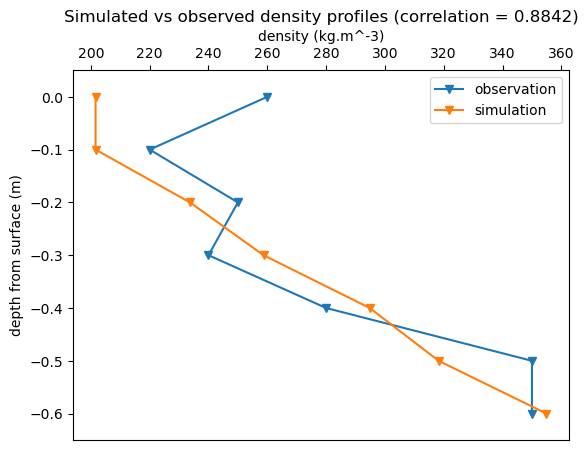

In [98]:
observed_ro_profile = [350, 350, 280, 240, 250, 220, 260]    # TODO make a netcdf file from the pits? > use density_profile() function?
                                                             # Careful to put the data in the correct order, from bottom to top
sampling_length = 0.1
bottom_depth = round( (len(observed_ro_profile)-1) * sampling_length, 1 )      # TODO there seems to be a issue with the length od the arrays, check the expected len of layers_indices
simulated_ro_profile = density_profile(bottom_depth, sampling_length, depth_evolution[-1], ro_layer_evolution[-1])

correlation_ro = p_correl_measure(simulated_ro_profile, observed_ro_profile)

fig = plt.figure()
ax = fig.add_subplot()

depths_array = np.linspace(0, -bottom_depth, len(observed_ro_profile))
ax.plot(list(reversed(observed_ro_profile)), depths_array, marker='v', label='observation')
ax.plot(list(reversed(simulated_ro_profile)), depths_array, marker='v', label='simulation')

ax.set_xlabel('density (kg.m^-3)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_ylim(-bottom_depth-sampling_length/2, sampling_length/2)
ax.set_ylabel('depth from surface (m)')

plt.title('Simulated vs observed density profiles (correlation = ' + str(round(correlation_ro, 4)) + ')')
plt.legend()
plt.show()

# TODO do this for several pits and save the results to do statistics

In [112]:
marker_layer_indices = [1, 2]   # indices of the layers directly below ice interfaces

observed_swe = [10, 25]   # corresponding SWE above these layers TODO netcdf file with observations? > use get_data_from_marker() function?
observed_ave_density = [269, 350]

simulated_swe = [get_data_from_marker(i, ro_layer_evolution[-1], depth_evolution[-1])[0] for i in marker_layer_indices]
simulated_ave_density = [get_data_from_marker(i, ro_layer_evolution[-1], depth_evolution[-1])[2] for i in marker_layer_indices]

# TODO save results for statistics

## 3. Height of layers validation

In [113]:
marker_layer_indices = [1, 2]   # indices of the layers directly below ice interfaces

observed_heights = [70, 120]   # corresponding height above these layers TODO netcdf file with observations? > use get_data_from_marker() function?
observed_total_height = 150

simulated_heights = [get_data_from_marker(i, ro_layer_evolution[-1], depth_evolution[-1])[1] for i in marker_layer_indices]
simulated_total_height = sum(depth_evolution[-1][i] for i in range(len(depth_evolution[-1])))

# TODO save results for statistics

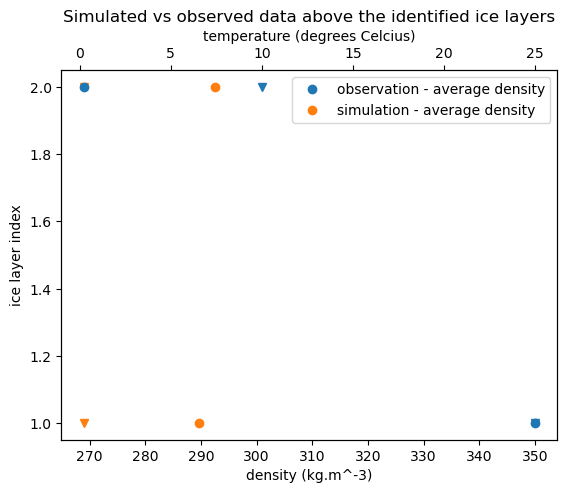

In [122]:
# Plot the SWE and height results on the same graph > really? does it make sens?

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(list(reversed(observed_swe)), marker_layer_indices, marker='v', linestyle='None', label='observation - swe')
ax.plot(list(reversed(simulated_swe)), marker_layer_indices, marker='v', linestyle='None', label='simulation - swe')

# ax.plot(list(reversed(observed_heights)), marker_layer_indices, marker='*', linestyle='None', label='observation - height')
# ax.plot(list(reversed(simulated_heights)), marker_layer_indices, marker='*', linestyle='None', label='simulation - height')

ax2=ax.twiny()
ax2.plot(list(reversed(observed_ave_density)), marker_layer_indices, marker='o', linestyle='None', label='observation - average density')
ax2.plot(list(reversed(simulated_ave_density)), marker_layer_indices, marker='o', linestyle='None', label='simulation - average density')

ax.set_xlabel('temperature (degrees Celcius)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax2.set_xlabel('density (kg.m^-3)')
ax2.xaxis.tick_bottom()
ax2.xaxis.set_label_position('bottom')

#ax.set_ylim(-bottom_depth-sampling_length/2, sampling_length/2)
ax.set_ylabel('ice layer index')

plt.title('Simulated vs observed data above the identified ice layers')
plt.legend()
plt.show()

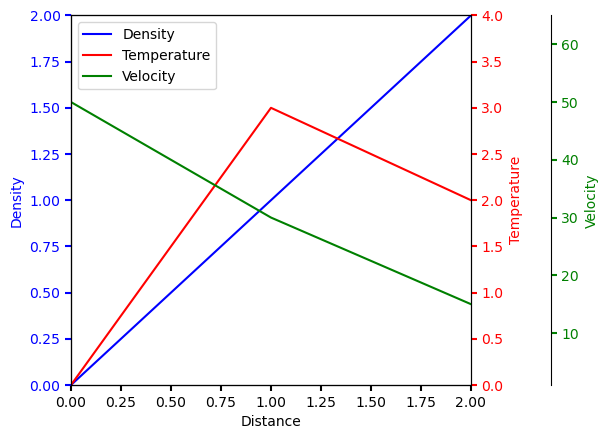

In [123]:

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot([0, 1, 2], [0, 1, 2], "b-", label="Density")
p2, = twin1.plot([0, 1, 2], [0, 3, 2], "r-", label="Temperature")
p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Velocity")

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
twin1.set_ylim(0, 4)
twin2.set_ylim(1, 65)

ax.set_xlabel("Distance")
ax.set_ylabel("Density")
twin1.set_ylabel("Temperature")
twin2.set_ylabel("Velocity")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()

## 4. Temperature profile validation

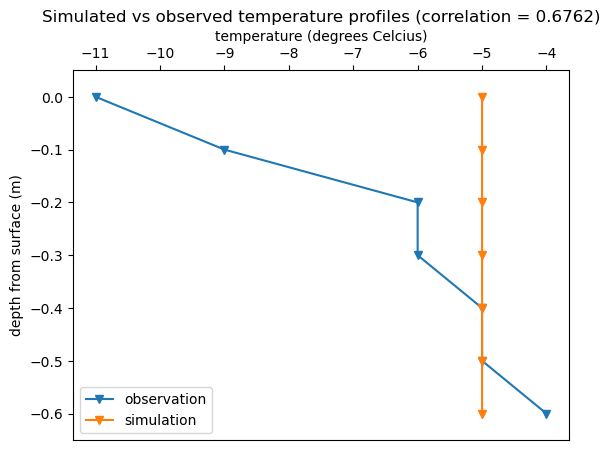

In [99]:
observed_temp_profile = [-4, -5, -5, -6, -6, -9, -11]    # TODO make a netcdf file from the pits? > use temp_profile() function?
                                                             # Careful to put the data in the correct order, from bottom to top
sampling_length = 0.1
bottom_depth = round( (len(observed_temp_profile)-1) * sampling_length, 1 )      # TODO there seems to be a issue with the length od the arrays, check the expected len of layers_indices
simulated_temp_profile = temp_profile(bottom_depth, sampling_length, depth_evolution[-1], temperature_evolution[-1])

correlation_temp = p_correl_measure(simulated_temp_profile, observed_temp_profile)

fig = plt.figure()
ax = fig.add_subplot()

depths_array = np.linspace(0, -bottom_depth, len(observed_temp_profile))
ax.plot(list(reversed(observed_temp_profile)), depths_array, marker='v', label='observation')
ax.plot(list(reversed(simulated_temp_profile)), depths_array, marker='v', label='simulation')

ax.set_xlabel('temperature (degrees Celcius)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_ylim(-bottom_depth-sampling_length/2, sampling_length/2)
ax.set_ylabel('depth from surface (m)')

plt.title('Simulated vs observed temperature profiles (correlation = ' + str(round(correlation_temp, 4)) + ')')
plt.legend()
plt.show()

# TODO do this for several pits and save the results to do statistics